In [1]:
import paho.mqtt.client as paho
import numpy as np
import random
import json
import networkx as nx
from node import EpidemicGraph, TransitionDiagram, calc_R0
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime
from IPython.display import clear_output
# %matplotlib inline

In [2]:
broker_ip = '192.168.0.104'
broker_ip = 'localhost'
# broker_ip = '10.1.199.251'
# broker_ip = '10.101.6.111'
broker_ip = '10.101.21.2'
connflag = False

In [3]:
def plot(G, title='step_1', ns=1000, fs=12, lim=2, figsize=(5, 5)):
    pos = nx.get_node_attributes(G, 'position')
    ids = {i:i for i in range(N)}
    print('Total node number', N)

    s_a = [x for x,y in G.nodes(data=True) if y['state']=='S_a']
    s_s = [x for x,y in G.nodes(data=True) if y['state']=='S_s']
    i1_a = [x for x,y in G.nodes(data=True) if y['state']=='I1_a']
    i1_s = [x for x,y in G.nodes(data=True) if y['state']=='I1_s']
    i2_a = [x for x,y in G.nodes(data=True) if y['state']=='I2_a']
    i2_s = [x for x,y in G.nodes(data=True) if y['state']=='I2_s']


    fig = plt.figure(figsize=figsize)
    nx.draw_networkx_edges(G, pos, alpha=0.8)
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=s_a, node_color='#66ff99')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=s_s, node_color='#006600')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i1_a, node_color='#ff6666')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i1_s, node_color='#cc0000')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i2_a, node_color='#3399ff')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i2_s, node_color='#0000cc')
    nx.draw_networkx_labels(G, pos, ids, font_size=fs)

    plt.title(title)
    red_patch = mpatches.Patch(color='red', label='I1')
    blue_patch = mpatches.Patch(color='blue', label='I2')
    green_patch = mpatches.Patch(color='green', label='S')
    plt.legend(handles=[green_patch, red_patch, blue_patch])
    plt.xlim(0, lim)
    plt.ylim(0, lim)
    return plt, fig

In [4]:
mqttc = paho.Client()
counter = 0
N = 900
format_date = "%d %b %Y %H%M%S.%f"

def on_connect(client, userdata, flags, rc):
    global connflag
    #if connection is successful, rc value will be 0
    print("Connection returned result: " + str(rc) )
    connflag = True

def on_message(client, userdata, msg): 
    print("-t {} | -p {}".format(msg.topic, msg.payload.decode()) )
    
def on_state(client, userdata, msg): 
    global G, counter
    counter += 1
    name = datetime.now().strftime(format_date)
    js = json.loads(msg.payload.decode())
    G.node[js['pi_id']]['state'] = js['state']
#     if counter%N == 0:
#         plt, fig = plot(G, 'step {}'.format((counter-1)//N), **plt_set)
#         fig.savefig('figures/{}.png'.format(name))
#         plt.close()
    log = "-t {} | -p {}".format(msg.topic, msg.payload.decode())
    print( log)
    with open("log.txt", "a") as myfile:
        myfile.write("{},{}\n".format(name, log))
        
def on_finish(client, userdata, msg):  # on finish step
    global node_set
    log = "-t {} | -p {}".format(msg.topic, msg.payload.decode())
    with open("log_node_set.txt", "a") as myfile:
        myfile.write("{}\n".format(log))
    node_id = msg.payload.decode()
    node_set.remove(node_id)
    print(node_set)
#     with open("log_node_set.txt", "a") as myfile:
#         myfile.write("{},{}\n".format(node_set))
    if len(node_set) == 0:
#         mqttc.publish('next', 'dummy_msg', qos=2)
        node_set = {str(x) for x in range(N)}
        clear_output(wait=True)
    
    
node_set = {str(x) for x in range(N)}
mqttc.on_connect = on_connect
mqttc.on_message = on_message
mqttc.message_callback_add("state", on_state)
mqttc.message_callback_add("finish", on_finish)

mqttc.connect(broker_ip)
mqttc.loop_start()
mqttc.subscribe('state', 2)
mqttc.subscribe('finish', 2)

Connection returned result: 0


(0, 2)

((16.516293489282592+0j), (16.516293489282592+0j)) (1, 0)
Total node number 900


/home/dd/.virtualenvs/pi/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


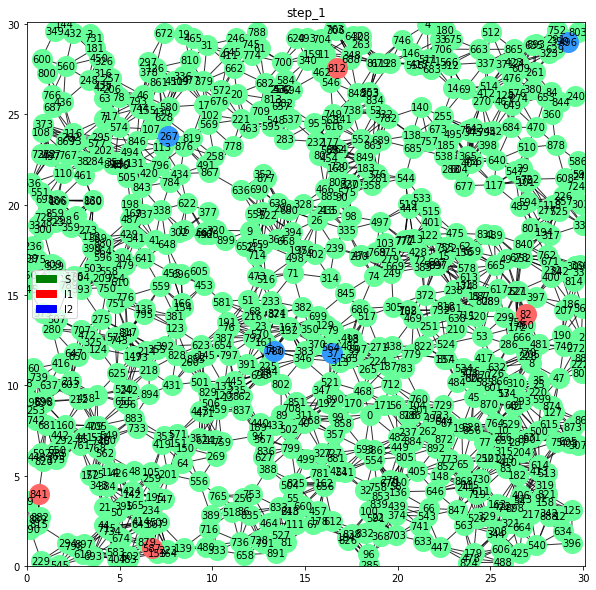

In [6]:
paramet = {
        'alpha': [0.5, 0.5], # infect rate 
        'mu': [0.5, 0.5], # sleep s 
        'gamma': [0.1, 0.1], # rec rate 
        'lambda': [0.7, 0.2], # sleep I1 
        'kappa': [0.7, 0.2] # sleep I2    % [I2_s -> I2_a, I2_a -> I2_s]
    }
np.random.seed(315)  # structure
random.seed(6)       # infected
# N = 5
r = 2
number_subgraphs = 0

while number_subgraphs != 1:
    a = EpidemicGraph(N,r,paramet,I1_a=4, I2_a=4, grid_size=[30, 30], create=True) # net='Uniform Grid'
    number_subgraphs = len(list(nx.connected_component_subgraphs(a.G)))
    number_isolated_nodes = len(list(nx.isolates(a.G)))
    print(calc_R0(a.G, paramet), (number_subgraphs, number_isolated_nodes))

G = a.G
# G.node[0]['state'] = 'S_s'

plt_set = {
    'ns': 400, 
    'fs': 10,
    'lim': 30.1, 
    'figsize': (10,10)
}
plt, fig = plot(G, **plt_set) #  ns=300, fs=6,lim=5
# plt.show()
fig.savefig('figures/_.png')

In [7]:
G.node[1]

msg_list = []
for node_id in range(N):
    neighbours = list(G[node_id])
    msg = {
        "id": node_id,
        "state": G.node[node_id]['state'],
        "neighbours": neighbours
    }
    msg_list.append(msg)
    print(msg)
    
mqttc.publish('init', json.dumps(msg_list))

{'id': 0, 'state': 'S_a', 'neighbours': [56, 99, 170, 171, 386, 468, 482, 593, 858]}
{'id': 1, 'state': 'S_a', 'neighbours': [212, 215, 242, 296, 409, 458, 530, 603, 625, 655, 705]}
{'id': 2, 'state': 'S_a', 'neighbours': [88, 186, 190, 207, 222, 272, 561, 740]}
{'id': 3, 'state': 'S_a', 'neighbours': [144, 181, 326, 349, 432, 450, 731]}
{'id': 4, 'state': 'S_a', 'neighbours': [33, 146, 180, 511, 675, 706, 746]}
{'id': 5, 'state': 'S_a', 'neighbours': [9, 59, 97, 211, 364, 473, 522, 557, 652, 668, 714, 899]}
{'id': 6, 'state': 'S_a', 'neighbours': [106, 119, 130, 273, 298, 300, 359, 369, 390, 691, 725, 823, 859, 860, 886]}
{'id': 7, 'state': 'S_a', 'neighbours': [63, 73, 78, 116, 202, 206, 295, 427, 574, 577, 717, 735]}
{'id': 8, 'state': 'S_a', 'neighbours': [25, 35, 47, 205, 220, 228, 286, 310, 481, 632, 666, 770, 866]}
{'id': 9, 'state': 'S_a', 'neighbours': [5, 59, 97, 211, 320, 364, 522, 557, 652, 714, 899]}
{'id': 10, 'state': 'S_a', 'neighbours': [42, 77, 121, 204, 219, 250, 266

In [ ]:
# node_set = {str(x) for x in range(5)}
# mqttc.publish('finish', '14', qos=2)
node_set

In [ ]:
mqttc.loop_stop()

In [ ]:
mqttc.publish('next', 'dummy_msg', qos=2)

In [ ]:
mqttc.publish('stop', 'dummy_msg', qos=2)

In [ ]:
mqttc.publish('kill', 'process die', qos=2)

In [ ]:
mqttc.publish('paramet', json.dumps(paramet), qos=2)

In [8]:
mqttc.publish('start', 'dummy_msg', qos=2)

-t state | -p {"state": "S_a", "pi_id": 0, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 1, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 2, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 3, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 4, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 5, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 6, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 7, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 8, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 9, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 10, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 11, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 12, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 13, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 14, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 15, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 16, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 17, "step": 0}
-t state | -p {"stat

-t state | -p {"state": "S_a", "pi_id": 293, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 294, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 295, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 296, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 297, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 298, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 299, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 300, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 301, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 302, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 303, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 304, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 305, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 306, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 307, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 308, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 309, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 310, "st

-t state | -p {"state": "S_a", "pi_id": 680, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 681, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 682, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 683, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 684, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 685, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 686, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 687, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 688, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 689, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 690, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 691, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 692, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 693, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 694, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 695, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 696, "step": 0}
-t state | -p {"state": "S_a", "pi_id": 697, "st

{'626', '215', '551', '764', '146', '733', '292', '815', '583', '459', '738', '277', '351', '591', '356', '205', '664', '72', '134', '706', '498', '229', '703', '170', '616', '649', '800', '830', '247', '18', '816', '818', '595', '688', '710', '716', '369', '152', '189', '235', '204', '490', '554', '23', '280', '291', '448', '482', '252', '413', '232', '784', '449', '821', '83', '827', '202', '64', '486', '299', '836', '810', '364', '117', '65', '472', '545', '725', '648', '891', '190', '428', '169', '36', '9', '327', '385', '858', '312', '543', '246', '138', '343', '183', '297', '112', '144', '518', '837', '166', '887', '829', '667', '420', '178', '33', '19', '681', '708', '876', '731', '651', '568', '485', '355', '642', '779', '360', '57', '794', '82', '603', '684', '462', '384', '717', '707', '546', '293', '533', '685', '758', '39', '375', '379', '121', '479', '531', '690', '730', '416', '548', '691', '854', '85', '400', '586', '366', '411', '408', '224', '467', '513', '187', '289',

{'626', '215', '551', '764', '146', '733', '292', '815', '459', '738', '277', '351', '591', '205', '664', '72', '134', '706', '229', '703', '170', '616', '800', '830', '247', '18', '816', '818', '595', '688', '710', '716', '369', '152', '189', '235', '204', '490', '554', '23', '291', '448', '482', '252', '413', '232', '784', '449', '821', '83', '827', '202', '836', '117', '65', '472', '545', '725', '891', '190', '428', '169', '36', '9', '327', '385', '858', '312', '543', '246', '138', '343', '183', '297', '112', '144', '518', '837', '887', '829', '667', '420', '178', '33', '19', '681', '708', '876', '651', '568', '485', '355', '642', '779', '360', '57', '603', '684', '462', '384', '717', '707', '546', '293', '685', '758', '39', '375', '379', '121', '479', '531', '690', '730', '416', '548', '691', '854', '85', '400', '586', '366', '411', '408', '224', '467', '513', '187', '289', '233', '834', '401', '853', '873', '476', '186', '70', '637', '729', '125', '523', '407', '179', '55', '601',

{'626', '215', '551', '764', '733', '292', '815', '459', '738', '277', '591', '664', '72', '134', '229', '703', '170', '247', '18', '816', '595', '688', '710', '369', '189', '235', '204', '490', '554', '23', '291', '448', '482', '252', '413', '784', '449', '821', '83', '827', '202', '836', '65', '472', '545', '725', '891', '428', '169', '36', '9', '327', '385', '858', '543', '246', '138', '183', '297', '518', '837', '887', '829', '667', '420', '178', '19', '681', '708', '876', '651', '485', '355', '642', '779', '360', '57', '603', '684', '462', '717', '707', '546', '293', '758', '39', '375', '379', '121', '479', '690', '730', '416', '548', '691', '854', '85', '400', '586', '366', '408', '224', '467', '513', '187', '289', '233', '834', '401', '853', '873', '476', '186', '70', '637', '729', '125', '523', '407', '179', '55', '601', '148', '599', '781', '614', '669', '848', '199', '561', '868', '869', '273', '687', '431', '52', '155', '278', '849', '519', '406', '51', '777', '102', '309', 

{'626', '215', '551', '764', '733', '815', '459', '738', '277', '664', '72', '134', '170', '247', '18', '369', '189', '235', '204', '490', '23', '448', '482', '252', '784', '449', '821', '827', '202', '65', '725', '428', '169', '36', '9', '327', '858', '543', '297', '518', '829', '667', '420', '681', '708', '876', '651', '355', '779', '360', '57', '603', '293', '121', '479', '691', '854', '400', '586', '366', '408', '513', '233', '834', '853', '873', '476', '186', '637', '125', '179', '55', '601', '148', '599', '781', '669', '868', '273', '431', '155', '278', '849', '406', '51', '309', '164', '527', '790', '8', '753', '654', '492', '650', '251', '888', '193', '832', '182', '885', '660', '866', '792', '474', '230', '111', '321', '484', '653', '290', '500', '889', '610', '100', '174', '659', '241', '825', '344', '380', '217', '769', '783', '49', '40', '303', '242', '778', '86', '563', '81', '99', '196', '457', '608', '656', '136', '699', '767', '686', '256', '698', '200', '141', '627', '

In [ ]:
# mqttc.reinitialise()
# mqttc.loop_start()
msg = {
                'step': 22, 
                'pi_id': 27,  # 27
                'state': 'S_a'
            }
mqttc.publish('27', json.dumps(msg), 2) 

In [ ]:
# a = ['python node_{0}/pi_main_2.py node_{0}'.format(i) for i in range(0, 5)]
# str.join(' & ', a)

# with open('node_id.json') as f:
#     my_id_list = json.load(f)

# my_nodes = {node_id: node_id**2 for node_id in my_id_list}
node_list = list(range(5, 10))
node_list
